<a href="https://colab.research.google.com/github/ShubhamJadhav03/21-days-pytorch/blob/main/Pytorch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Binary Classification

1. We will make classification Data ready!

In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42
                    )



In [2]:
print(f"First 5 X and y features:\n{X[:5]} \n\n {y[:5]}")

First 5 X and y features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 

 [1 1 1 1 0]


In [3]:
import pandas as pd

circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:,1],
                        "label": y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
circles.label.value_counts()

,count
label,
1,500
0,500


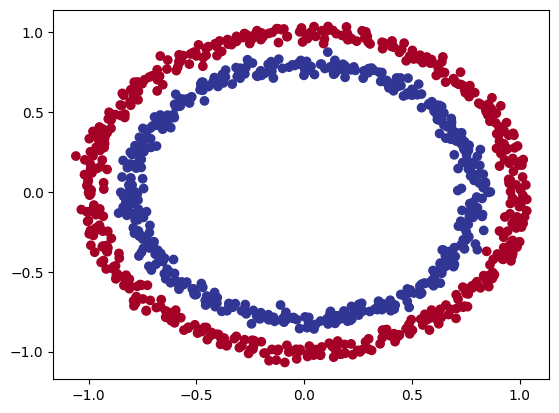

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu
            )

1.1 Input and output shapes

One of the most common errors in deep learning is shape errors.

I like referring to it as input and output shapes.

Ask yourself:

"What shapes are my inputs and what shapes are my outputs?"

Let's find out.

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [8]:
#This tells us the second dimension for X means it has two features (vector) where as y has a single feature (scalar).

1.2 Turn data into tensors and create train and test splits

In [9]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42)

In [12]:

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

2. Building a model

In [13]:
import torch
from torch import nn

device = "cude" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [14]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

You can also do the same as above using nn.Sequential.


nn.Sequential performs a forward pass computation of the input data through the layers in the order they appear.

In [15]:
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{[x.argmax().item() for x in untrained_preds[:10]]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#Now lets setup a loss function

Since we are conducting binary classification for this type of proble Binary cross entropy loss is the most ideal type of function

Now based on loss we need to optimise out Neural Network so SGD can be used.

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
 # BCEWithLogitsLoss = sigmoid built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.1)

In [18]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()  # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc

#3. Train model

Okay, now we've got a loss function and optimizer ready to go, let's train a model.

3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [19]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.4821],
        [ 0.4864],
        [ 0.2705],
        [ 0.5429],
        [-0.0473]], grad_fn=<SliceBackward0>)

raw outputs are basically called as logits

In [20]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6182],
        [0.6193],
        [0.5672],
        [0.6325],
        [0.4882]], grad_fn=<SigmoidBackward0>)

sigmoid function works by taking any real-valued input and "squashing" it into an output between 0 and 1

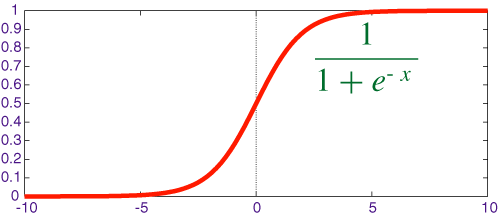

prediction probabilities

In [21]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))


tensor([True, True, True, True, True])


In [22]:
# Get rid of extra dimension
y_preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], grad_fn=<RoundBackward0>)

In [23]:
# Get rid of extra dimension
y_preds.squeeze()

tensor([1., 1., 1., 1., 0.], grad_fn=<SqueezeBackward0>)

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

#3.2 Building a training and testing Loop

In [25]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70387, Accuracy: 54.62% | Test loss: 0.70864, Test acc: 54.00%
Epoch: 10 | Loss: 0.69899, Accuracy: 52.62% | Test loss: 0.70358, Test acc: 51.00%
Epoch: 20 | Loss: 0.69681, Accuracy: 52.00% | Test loss: 0.70121, Test acc: 49.00%
Epoch: 30 | Loss: 0.69574, Accuracy: 51.38% | Test loss: 0.69994, Test acc: 48.00%
Epoch: 40 | Loss: 0.69512, Accuracy: 51.25% | Test loss: 0.69917, Test acc: 50.00%
Epoch: 50 | Loss: 0.69472, Accuracy: 50.50% | Test loss: 0.69864, Test acc: 49.50%
Epoch: 60 | Loss: 0.69443, Accuracy: 50.88% | Test loss: 0.69824, Test acc: 48.50%
Epoch: 70 | Loss: 0.69420, Accuracy: 50.62% | Test loss: 0.69791, Test acc: 48.00%
Epoch: 80 | Loss: 0.69402, Accuracy: 51.12% | Test loss: 0.69764, Test acc: 47.00%
Epoch: 90 | Loss: 0.69387, Accuracy: 50.75% | Test loss: 0.69741, Test acc: 47.50%


#4. Make predictions and evaluate the model

In [26]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

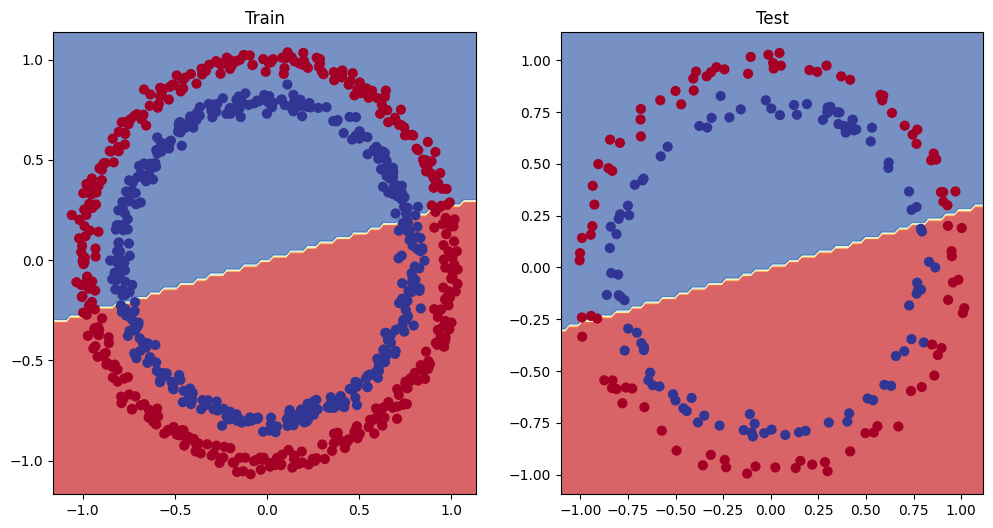

In [27]:
#Plot decision boundries for training and test set
plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
plt.title("Train")

plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

How could we improve this?


#5. Improving a model (from a model perspective)

In [28]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 10)
    self.layer_2 = nn.Linear(10, 10)
    self.layer_3 = nn.Linear(10, 1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
loss_fn = nn.BCEWithLogitsLoss() #doesnt requires sigmoid on input

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [30]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


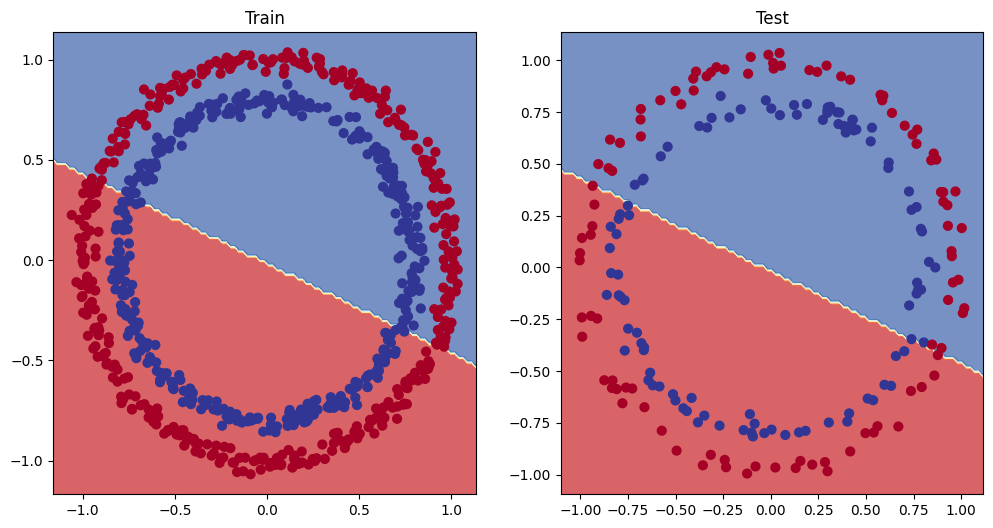

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Our model is still drawing a straight line between the red and blue dots.

If our model is drawing a straight line, could it model linear data?

#5.1 Preparing Data to see if our model can model a straight line

In [32]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [33]:
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


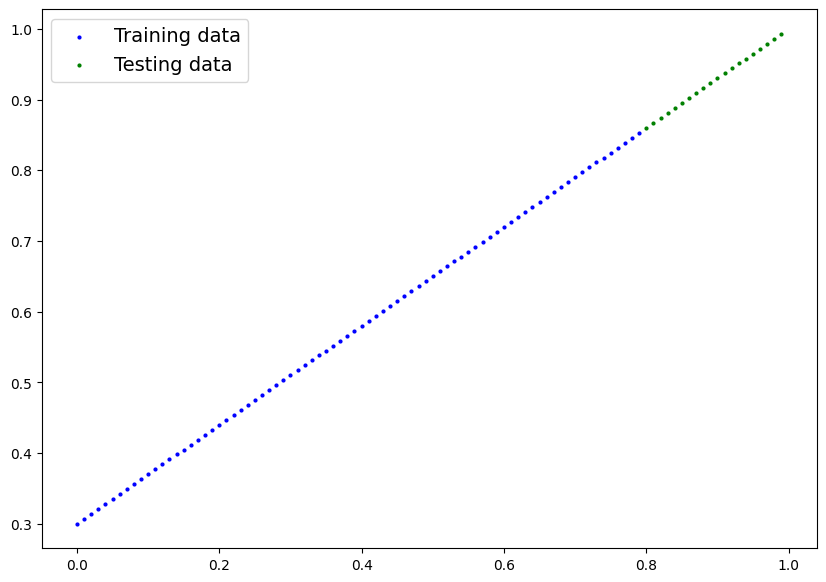

In [34]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

#5.2 Adjusting model_1 to fit a straight line
Now we've got some data, let's recreate model_1 but with a loss function suited to our regression data.

In [35]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

We'll setup the loss function to be nn.L1Loss() (the same as mean absolute error) and the optimizer to be torch.optim.SGD().

In [36]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [37]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


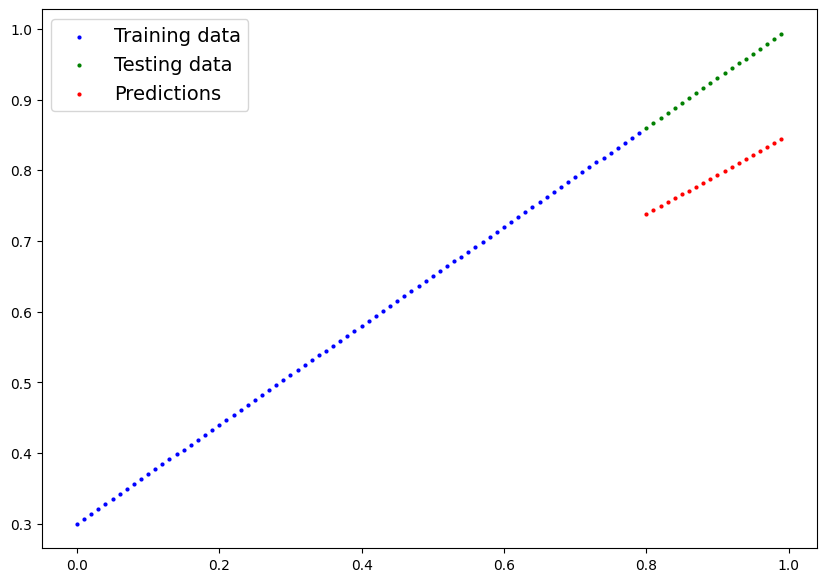

In [38]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

#6. The missing piece: non-linearity

6.1 Recreating non-linear data (red and blue circles)

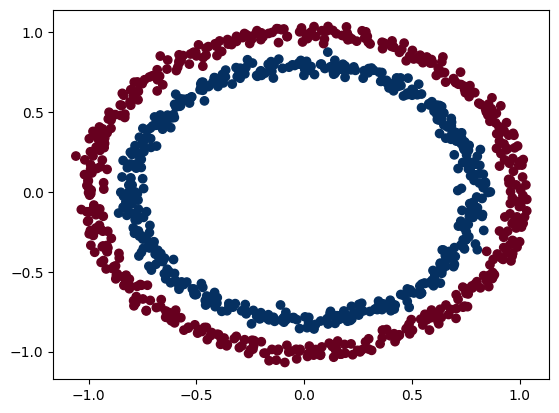

In [39]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [40]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

#6.2 Building a model with non-linearity
Now here comes the fun part.

So whats going on right now is that our model can only be used for regression for line

But our problem of this cirlce is a non linear problem for which we would need to use non-linear activation functions

PyTorch has a bunch of ready-made non-linear activation functions that do similar but different things.

One of the most common and best performing is ReLU) (rectified linear-unit, torch.nn.ReLU()).


In [41]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [42]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [43]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [44]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

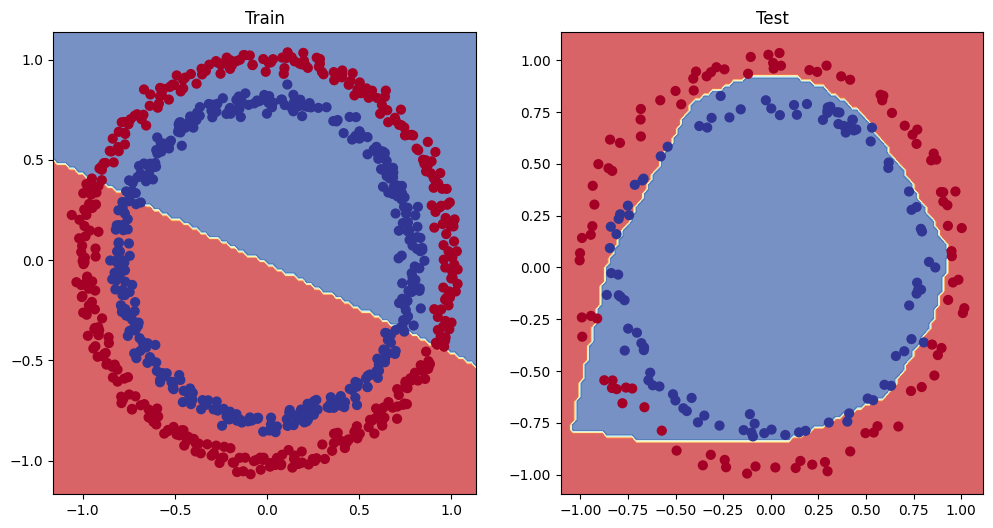

In [45]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

  .

.

#Multi Classification Model

#1. create Multi class Data

* Create some multi-class data with make_blobs().

* Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).

* Split the data into training and test sets using train_test_split().

* Visualize the data.


In [46]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [47]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# Turn the data into tensors

In [48]:
#Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [49]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

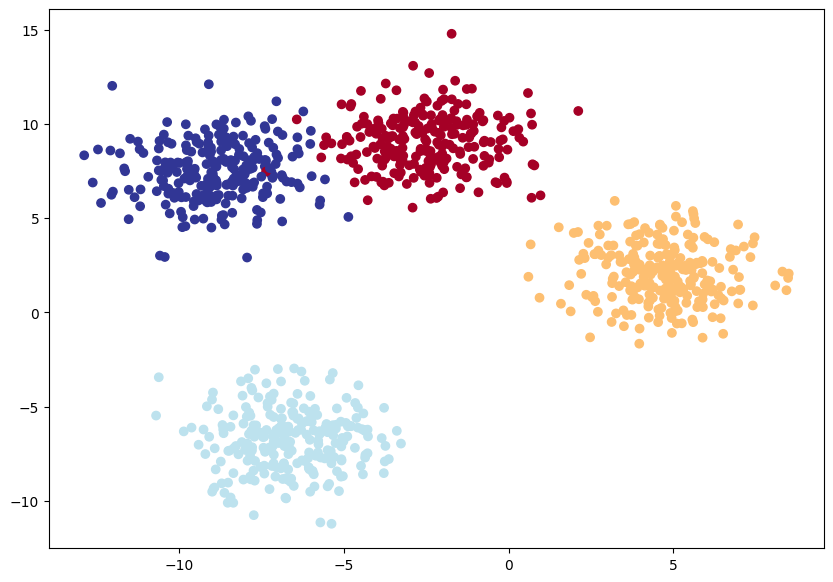

In [50]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

#2 Building a multi-class classification model in PyTorch

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [52]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

# 3 Creating a loss function and optimizer for a multi-class PyTorch model

In [53]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

#4 Getting prediction probabilities for a multi-class PyTorch model

In [54]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [55]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [56]:
y_logits = model_4(X_blob_test.to(device))
# Perform softmax calculation on logits across dimension 1 to get prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)


In [57]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [58]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
tensor(3)


#5 Creating a training and testing loop for a multi-class PyTorch model

In [59]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


#6 Making and evaluating predictions with a PyTorch multi-class model

In [61]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [62]:
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


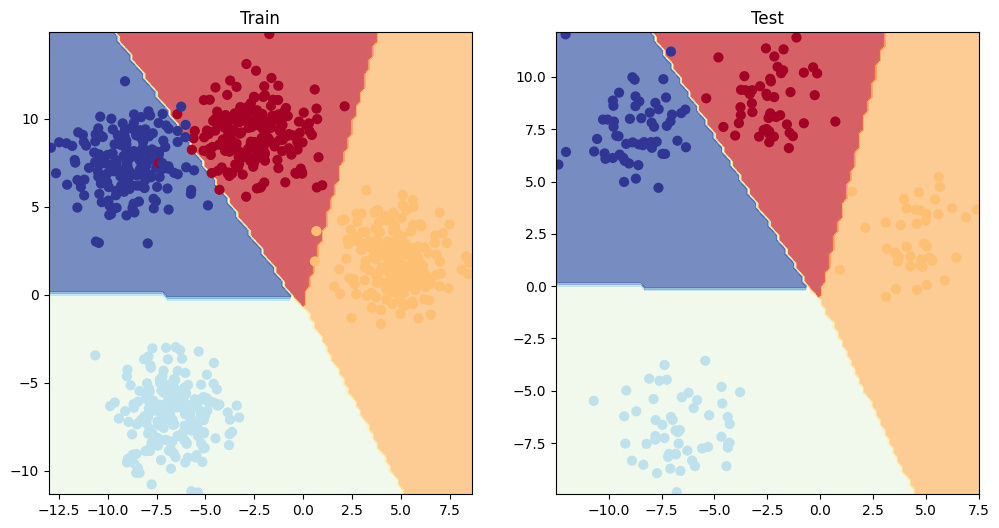

In [63]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [64]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 7.2 MB/s eta 0:00:00


tensor(0.9950)